<a href="https://colab.research.google.com/github/doronin99/ProductClassificationService/blob/task1/notebooks/product_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [ ]:
pip install -q CatBoost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from wordcloud import WordCloud
from scipy.stats import chi2_contingency

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from catboost import CatBoostClassifier

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## EDA

In [ ]:
# Load the dataset from the file pricerunner_aggregate.csv
file_path = "https://raw.githubusercontent.com/doronin99/ProductClassificationService/main/pricerunner_aggregate.csv"
df = pd.read_csv(file_path)

In [ ]:
# Display the first few rows of the dataset for initial exploration
df.head()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [ ]:
# Remove leading and trailing whitespaces in column names
df.columns = df.columns.str.strip()

In [ ]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values

Product ID        0
Product Title     0
Merchant ID       0
Cluster ID        0
Cluster Label     0
Category ID       0
Category Label    0
dtype: int64

In [ ]:
# Convert numerical identifier columns to strings for categorical analysis
df['Merchant ID'] = df['Merchant ID'].astype('category')
df['Cluster ID'] = df['Cluster ID'].astype('category')
df['Category ID'] = df['Category ID'].astype('category')
cat_cols = ['Merchant ID', 'Cluster ID', 'Category ID']

In [ ]:
# Explore categorical features
# Unique values and counts for categorical features
categorical_summary = df.describe(include=['O', 'category'])

# Display the summaries
categorical_summary

,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
count,35311,35311,35311,35311,35311,35311
unique,30993,306,13233,12849,10,10
top,washing machine,3,38848,Canon IXUS 185,2622,Fridge Freezers
freq,90,2547,27,27,5501,5501


In [ ]:
# Grouping by 'Cluster Label' and counting the number of unique 'Cluster ID' values
grouped = df.groupby('Cluster Label')['Cluster ID'].nunique()

# Selecting only those rows where the number of unique 'Cluster ID' values is greater than 1
result = df[df['Cluster Label'].isin(grouped[grouped > 1].index)]
result

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
1631,1633,xiaomi mi a1 32gb rose gold,24,230,Xiaomi Mi A1 32GB Dual SIM,2612,Mobile Phones
1632,1634,xiaomi mi a1 smartphone 32gb dual sim 14cm,2,230,Xiaomi Mi A1 32GB Dual SIM,2612,Mobile Phones
1633,1635,xiaomi mi a1 4g 32gb dual sim rose gold eu,3,230,Xiaomi Mi A1 32GB Dual SIM,2612,Mobile Phones
1644,1646,mi a1 32gb gold,42,234,Xiaomi Mi A1 32GB Dual SIM,2612,Mobile Phones
1645,1647,xiaomi mi a1 lte 32gb gold,49,234,Xiaomi Mi A1 32GB Dual SIM,2612,Mobile Phones
...,...,...,...,...,...,...,...
34023,46023,swan sr11050bln tall retro fridge blue,22,46652,Swan SR11050BLN Blue,2623,Fridges
34024,46024,swan retro sr11050bln upright freestanding tal...,17,46652,Swan SR11050BLN Blue,2623,Fridges
34529,46543,381litre retro fridge class a red,123,46883,Britannia Breeze Retro Red,2623,Fridges
34530,46544,britannia breeze retro free standing refrigera...,31,46883,Britannia Breeze Retro Red,2623,Fridges


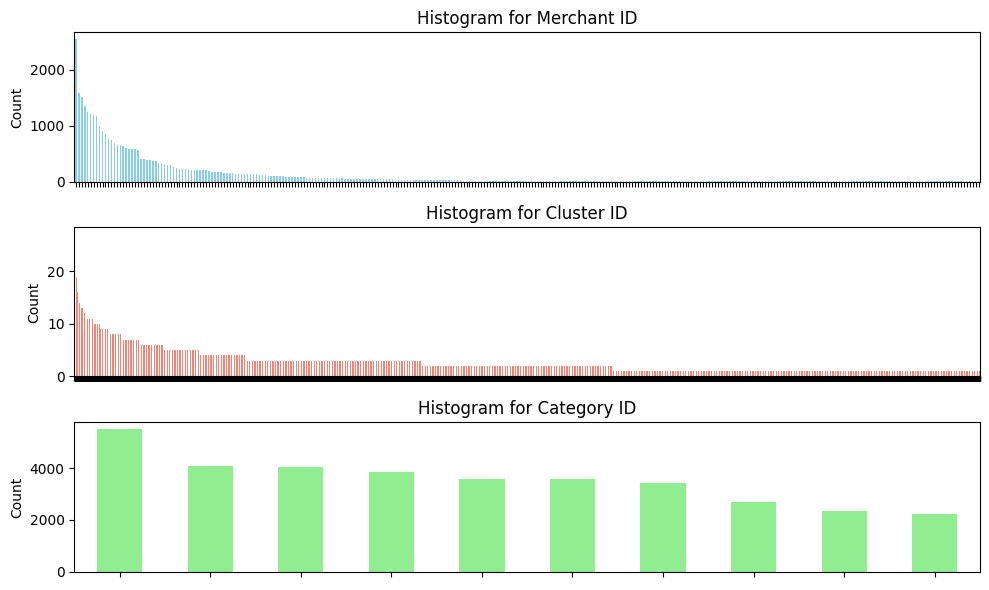

In [ ]:
# Plot histogram for 'Merchant ID'
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(3, 1, 1)
df['Merchant ID'].value_counts().plot(kind='bar', color='skyblue', legend=False)
plt.title('Histogram for Merchant ID')
plt.xlabel('')
plt.ylabel('Count')
ax1.set_xticklabels([])

# Plot histogram for 'Cluster ID'
ax2 = plt.subplot(3, 1, 2)
df['Cluster ID'].value_counts().plot(kind='bar', color='salmon', legend=False)
plt.title('Histogram for Cluster ID')
plt.xlabel('')
plt.ylabel('Count')
ax2.set_xticklabels([])

# Plot histogram for 'Category ID'
ax3 = plt.subplot(3, 1, 3)
df['Category ID'].value_counts().plot(kind='bar', color='lightgreen', legend=False)
plt.title('Histogram for Category ID')
plt.xlabel('')
plt.ylabel('Count')
ax3.set_xticklabels([])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

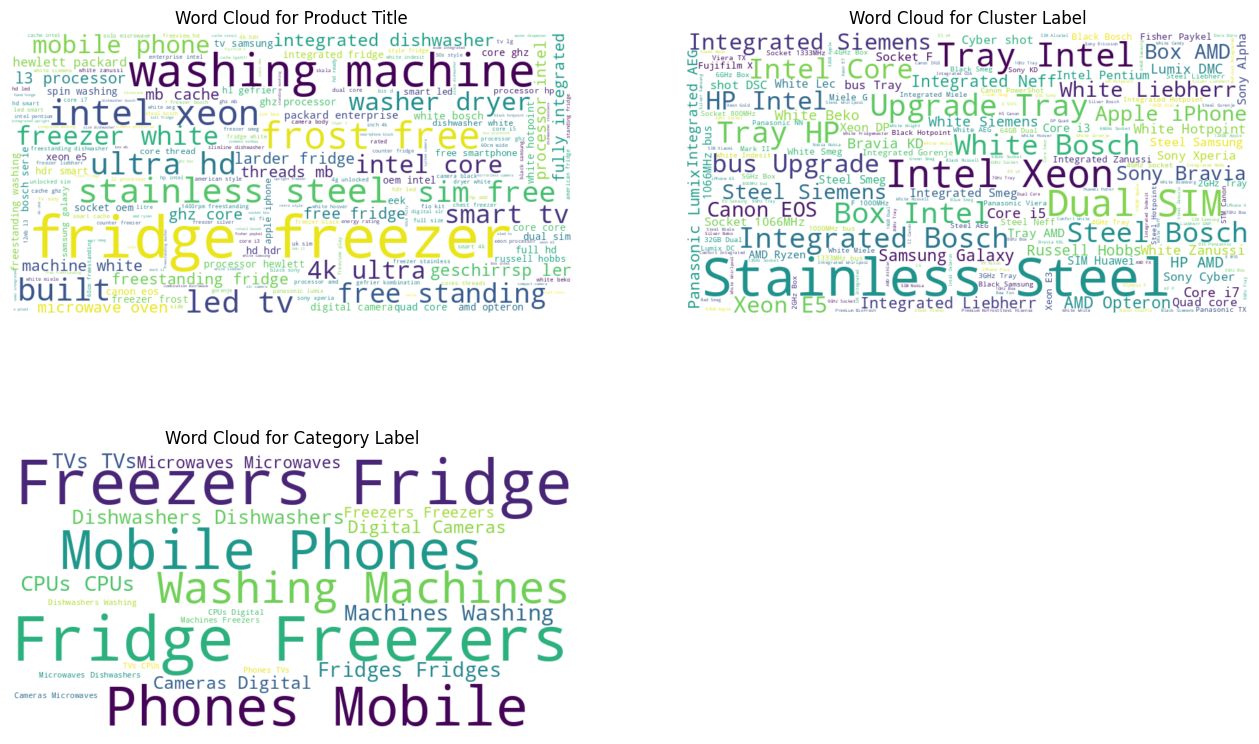

In [ ]:
# Word cloud for textual features (Product Title, Cluster Label, Category Label)
textual_features = ['Product Title', 'Cluster Label', 'Category Label']
plt.figure(figsize=(16, 10))

for i, feature in enumerate(textual_features, 1):
    plt.subplot(2, 2, i)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df[feature].astype(str)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {feature}")

plt.show()

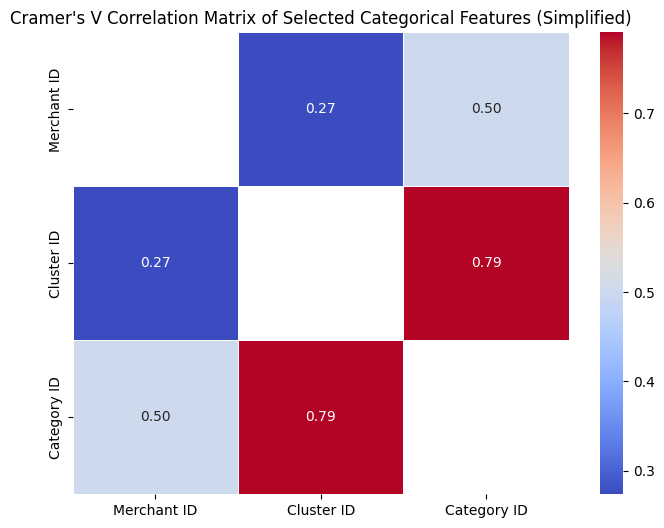

In [ ]:
# Calculate the Cramer's V correlation for selected categorical features
def cramers_v_simple(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate correlations between selected categorical features
categorical_corr_selected_simple = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

for i in cat_cols:
    for j in cat_cols:
        if i != j:
            categorical_corr_selected_simple.loc[i, j] = cramers_v_simple(df[i], df[j])

# Visualize the correlation matrix for selected categorical features using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(categorical_corr_selected_simple, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Cramer's V Correlation Matrix of Selected Categorical Features (Simplified)")
plt.show()

## CatBoost for categorical features

In [ ]:
# Split the data into training and testing sets
X = df[['Merchant ID', 'Cluster ID']]
y = df['Category ID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply oversampling to balance classes
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.05, random_state=42)

# Train the model on the balanced data
catboost_model.fit(X_train_resampled, y_train_resampled, cat_features=['Merchant ID', 'Cluster ID'])

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

0:	learn: 2.2048767	total: 1.03s	remaining: 8m 36s
1:	learn: 2.1356597	total: 1.97s	remaining: 8m 10s
2:	learn: 2.0802854	total: 2.9s	remaining: 8m 1s
3:	learn: 1.8215143	total: 3.82s	remaining: 7m 53s
4:	learn: 1.6477149	total: 4.74s	remaining: 7m 49s
5:	learn: 1.5160051	total: 5.67s	remaining: 7m 46s
6:	learn: 1.4097009	total: 6.58s	remaining: 7m 43s
7:	learn: 1.3212540	total: 7.52s	remaining: 7m 42s
8:	learn: 1.2458214	total: 8.43s	remaining: 7m 39s
9:	learn: 1.1805620	total: 9.36s	remaining: 7m 38s
10:	learn: 1.1234260	total: 10.5s	remaining: 7m 45s
11:	learn: 1.0727902	total: 12.3s	remaining: 8m 18s
12:	learn: 1.0273628	total: 14s	remaining: 8m 45s
13:	learn: 0.9855556	total: 15.3s	remaining: 8m 49s
14:	learn: 0.9485669	total: 16.2s	remaining: 8m 42s
15:	learn: 0.9141061	total: 17.1s	remaining: 8m 37s
16:	learn: 0.8833292	total: 18s	remaining: 8m 31s
17:	learn: 0.8552296	total: 18.9s	remaining: 8m 26s
18:	learn: 0.8300113	total: 19.8s	remaining: 8m 21s
19:	learn: 0.8059156	total: 

In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9288
Recall: 0.9124
F1-Score: 0.9149


In [ ]:
# Save the model to a file
with open('catboost_model.pkl', 'wb') as model_file:
    pickle.dump(catboost_model, model_file)

## Logistic Regression for text features

In [ ]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

# Load stopwords from NLTK
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])
    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', '', text)
    return text

# Create a new DataFrame to apply changes and keep the original DataFrame unchanged
df_processed = df.copy()

# Apply preprocessing to text features
df_processed['Product Title'] = df_processed['Product Title'].apply(preprocess_text)
df_processed['Cluster Label'] = df_processed['Cluster Label'].apply(preprocess_text)
df_processed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone plus 64gb silver,1,1,apple iphone plus 64gb,2612,Mobile Phones
1,2,apple iphone plus gb spacegrau,2,1,apple iphone plus 64gb,2612,Mobile Phones
2,3,apple mq8n2b/a iphone plus 64gb . 12mp sim fr...,3,1,apple iphone plus 64gb,2612,Mobile Phones
3,4,apple iphone plus 64gb space grey,4,1,apple iphone plus 64gb,2612,Mobile Phones
4,5,apple iphone plus gold . 64gb 4g unlocked sim...,5,1,apple iphone plus 64gb,2612,Mobile Phones
...,...,...,...,...,...,...,...
35306,47350,smeg fab28 60cm retro style right hand hinge f...,59,47517,smeg fab28 cream,2623,Fridges
35307,47351,smeg fab28 60cm retro style left hand hinge fr...,59,47518,smeg fab28 red,2623,Fridges
35308,47352,smeg fab28 60cm retro style left hand hinge fr...,59,47519,smeg fab28 pink,2623,Fridges
35309,47355,candy 60cm built larder fridge cru160nek,125,47524,candy cru16.,2623,Fridges


In [ ]:
# Select text features for the model
text_features = ['Product Title', 'Cluster Label']

# Concatenate text features into a single string
df_processed['Text Features'] = df_processed[text_features].agg(' '.join, axis=1)

# Create a TfidfVectorizer object to convert text into numerical format
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Convert text features into numerical format using TF-IDF
X_text = tfidf_vectorizer.fit_transform(df_processed['Text Features']).toarray()

# Target variable for text features
y_text_label = df_processed['Category ID']

# Split the data into training and testing sets for text features
X_train_text_label, X_test_text_label, y_train_text_label, y_test_text_label = train_test_split(
    X_text, y_text_label, test_size=0.2, random_state=42
)

# Initialize the Logistic Regression model for text features
logreg_text_label_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on text features
logreg_text_label_model.fit(X_train_text_label, y_train_text_label)

# Make predictions on the test set for text features
y_pred_text_label = logreg_text_label_model.predict(X_test_text_label)

In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_text_label, y_pred_text_label, average='weighted')
recall = recall_score(y_test_text_label, y_pred_text_label, average='weighted')
f1 = f1_score(y_test_text_label, y_pred_text_label, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9718
Recall: 0.9717
F1-Score: 0.9717


In [ ]:
# Save the model to a file
with open('logreg_model.pkl', 'wb') as model_file:
    pickle.dump(logreg_text_label_model, model_file)

## SVM for all features

In [ ]:
# Splitting the data into training and testing sets
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=42)

# Preparing text data using TF-IDF for Product Title and Cluster Label
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_text = tfidf_vectorizer.fit_transform(df_train['Text Features'])
X_test_text = tfidf_vectorizer.transform(df_test['Text Features'])

# Preparing categorical data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)

# Transforming and combining categorical data for the training set
X_train_cat = encoder.fit_transform(df_train[['Merchant ID', 'Cluster ID']].astype(str))

# Transforming and combining categorical data for the testing set
X_test_cat = encoder.transform(df_test[['Merchant ID', 'Cluster ID']].astype(str))

# Combining all features
X_train_final = hstack([X_train_text, X_train_cat], format='csr')
X_test_final = hstack([X_test_text, X_test_cat], format='csr')

# Scaling the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Target variable
y_train = df_train['Category ID']
y_test = df_test['Category ID']

# Creating and training the SVM model
svm_model = SVC(random_state=42)

# Training the model
svm_model.fit(X_train_scaled, y_train)

# Evaluating the model
y_pred = svm_model.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9835
Recall: 0.9829
F1-Score: 0.9830


In [ ]:
# Save the model to a file
with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)